In [1]:
!pip install kaggle --upgrade



In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d thienkhonghoc/affectnet
!unzip -q affectnet.zip -d /content/AffectNet

Dataset URL: https://www.kaggle.com/datasets/thienkhonghoc/affectnet
License(s): unknown


In [4]:
!pip install torch torchvision timm matplotlib tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [9]:
from torchvision import datasets

val_dataset = datasets.ImageFolder("/content/AffectNet/AffectNet/val")
print(val_dataset.class_to_idx)


{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7}


In [13]:
# Print the class-to-index mapping
print(val_dataset.class_to_idx)


{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7}



=== Full Validation Metrics ===
              precision    recall  f1-score   support

       Anger       0.60      0.62      0.61       100
     Disgust       0.66      0.48      0.55       100
        Fear       0.63      0.61      0.62       100
   Happiness       0.66      0.75      0.70       100
     Sadness       0.63      0.67      0.65       100
    Surprise       0.52      0.55      0.54       100
      Neutre       0.51      0.49      0.50       100
    Contempt       0.56      0.59      0.57       100

    accuracy                           0.59       800
   macro avg       0.60      0.59      0.59       800
weighted avg       0.60      0.59      0.59       800



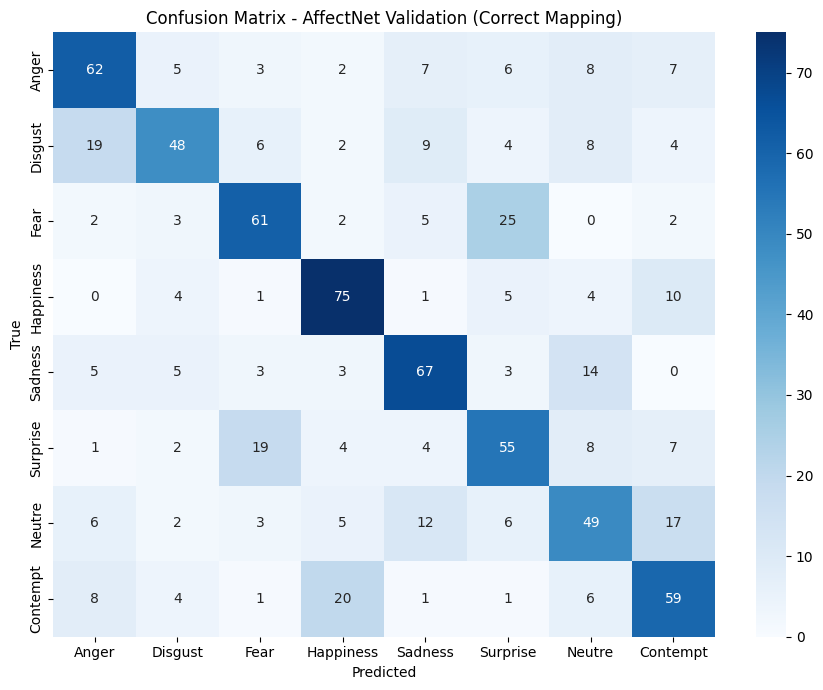


Showing some misclassified samples:


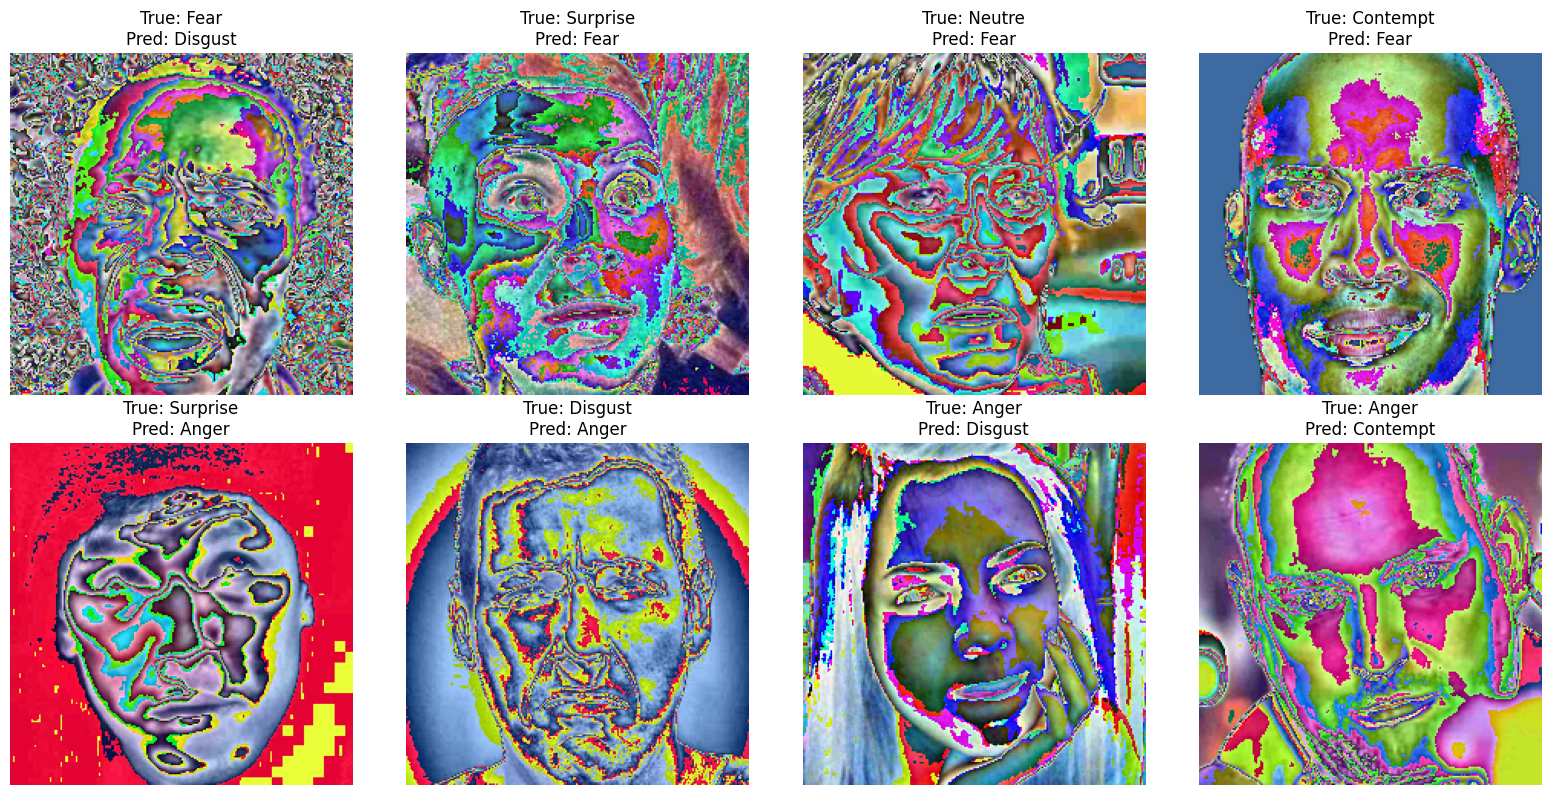

In [22]:
import torch
import torch.nn as nn
from torchvision.models import convnext_large, ConvNeXt_Large_Weights
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import os
import random

# === Config ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/content/affectnet_convnext_large_final_v2_70.pt"
val_path = "/content/AffectNet/AffectNet/val"  # path with 0-7 folders

emotion_labels = [
    "Anger", "Disgust", "Fear", "Happiness",
    "Sadness", "Surprise", "Neutre", "Contempt"
]

# === Transforms ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# === Dataset & Loader ===
val_dataset = datasets.ImageFolder(root=val_path, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# === Load Model ===
def load_model(path):
    model = convnext_large(weights=ConvNeXt_Large_Weights.IMAGENET1K_V1)
    model.classifier = nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.LayerNorm(model.classifier[2].in_features),
        nn.Dropout(0.5),
        nn.Linear(model.classifier[2].in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(512, 8)
    )
    state_dict = torch.load(path, map_location=device)
    state_dict = {k.replace("_orig_mod.", ""): v for k, v in state_dict.items()}
    model.load_state_dict(state_dict, strict=False)
    model.to(device)
    model.eval()
    return model

model = load_model(model_path)

# === Inference ===
y_true, y_pred, misclassified = [], [], []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

        # Collect misclassified
        for i in range(len(labels)):
            if preds[i] != labels[i]:
                misclassified.append((imgs[i].cpu(), labels[i].item(), preds[i].item()))


# === Report ===
print("\n=== Full Validation Metrics ===")
print(classification_report(y_true, y_pred, target_names=emotion_labels, digits=2))

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(9, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=emotion_labels,
            yticklabels=emotion_labels)
plt.title("Confusion Matrix - AffectNet Validation (Correct Mapping)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# === Show 8 Misclassified Images ===
def show_misclassified(misclassified, emotion_labels):
    sample = random.sample(misclassified, min(8, len(misclassified)))
    fig, axs = plt.subplots(2, 4, figsize=(16, 8))
    axs = axs.flatten()

    for i, (img_tensor, true_label, pred_label) in enumerate(sample):
        img = transforms.ToPILImage()(img_tensor)
        axs[i].imshow(img)
        axs[i].axis("off")
        axs[i].set_title(f"True: {emotion_labels[true_label]}\nPred: {emotion_labels[pred_label]}")

    for j in range(len(sample), 8):
        axs[j].axis("off")

    plt.tight_layout()
    plt.show()

print("\nShowing some misclassified samples:")
show_misclassified(misclassified, emotion_labels)
